# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 8 — GP Classifiaction on Binary MNIST

---

Submission by:

+ Batuhan, Oezcoemlekci, Matrikelnummer: 6300476

+ Aakarsh, Nair, Matrikelnummer: 6546577

In [1]:
# Numpy, JAX
import jax
from jax import jit
import jax.numpy as jnp
import numpy as np
jax.config.update("jax_enable_x64", True)  # use double-precision numbers

In [2]:
# Plotting
from matplotlib import pyplot as plt
from tueplots import bundles

%config InlineBackend.figure_formats = ["svg"]
%matplotlib inline
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 200})

In [3]:
# Import `gaussians.py`
import gaussians

### 0. Overview

In this week's exercise, we will apply Gaussian Process (GP) classification to a subset of the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Your task is to set up the optimization problem, find the posterior mode, define the GP posterior, and perform some analyses on the results. 

### 1. Training and Test Data

The data has already been prepared for you: `X_train` and `X_test` contain 600 training and 600 test images of the digits 1 and 4. The pixel values are normalized to numbers between -1 and 1. The labels (`1` for the digit 1 and `-1` for the digit 4) for the training and test images are stored in `y_train` and `y_test`. 

In [4]:
# Load MNIST data
data = jnp.load("binary_MNIST.npz")

# Extract data
X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]

In [5]:
def print_data_info(X, y, title):
    print(f"\n{title}:")
    print("X.shape = ", X.shape)
    print(f"X in range [{X.min()}, {X.max()}]")
    print("y.shape = ", y.shape)
    for target in jnp.unique(y):
        count = (y == target).sum()
        print(f"Target yi = {target}: Found {count} times")
        
print_data_info(X_train, y_train, "Training data")
print_data_info(X_test, y_test, "Test data")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)



Training data:
X.shape =  (600, 784)
X in range [-1.0, 1.0]
y.shape =  (600,)
Target yi = -1: Found 300 times
Target yi = 1: Found 300 times

Test data:
X.shape =  (600, 784)
X in range [-1.0, 1.0]
y.shape =  (600,)
Target yi = -1: Found 300 times
Target yi = 1: Found 300 times


Let's visualize some example images from the training and test data.

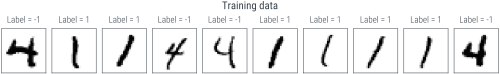

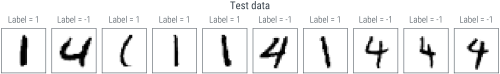

In [6]:
def show_mnist_img(ax, img, title=""):
    """Show a single MNIST image in `ax`."""
    
    ax.imshow(img.reshape(28, 28), cmap="Greys")
    ax.set_title(title)
    
    # Remove ticks and labels
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
def show_n_mnist_imgs(X_data, y_data, title, n=10):
    """Show the first `n` images from `X_data` with the labels."""
    n = min(n, X_data.shape[0])
    
    fig, axs = plt.subplots(1, n, figsize=(n * 0.7, 1.2))
    for idx in range(n):
        title_img = f"Label = {y_data[idx]}"
        show_mnist_img(axs[idx], X_data[idx, :], title_img)
    fig.suptitle(title)
    plt.show()
    
show_n_mnist_imgs(X_train, y_train, "Training data")
print("")
show_n_mnist_imgs(X_test, y_test, "Test data")

### 2. Loss Function

The first step in GP classification is finding the mode $\hat{f_X}$ of the posterior, i.e. 

\begin{align*}
\hat{f_X}
&= \text{argmax}_{f_X} p(f_X | X, y) \\
&= \text{argmin}_{f_X} \mathcal{L}(f_X), 
\end{align*}

where $\mathcal{L}(f_X) := - [\log(p(y | f_X)) + \log(p(f_X | X))]$ denotes the loss-function. We thus need to define the log-prior $\log(p(f_X | X))$ and the log-likelihood $\log(p(y | f_X))$. In order to solve the optimization problem, we will also need access to the gradients of these functions. In the theory exercises (a) and (b), your task is to give a derivation for the quantities given below.

**Log-prior:** The prior $p(f | X)$ is simply the GP prior (with mean function $m$ and covariance function $k$) on the latent function evaluated at $X$. So, it is a Gaussian $p(f_X | X) = \mathcal{N}(f; m(X), k(X, X))$. The log-density is therefore given by the quadratic

$$
\log(p(f_X | X)) 
= 
- \frac{1}{2} (f_X - m(X))^\top k(X, X)^{-1} (f_X - m(X))
- \frac{1}{2} \vert k(X, X) \vert
- \frac{N}{2} \log(2 \pi).
$$

Its gradient with respect to $f_X$ is given by $- k(X, X)^{-1} (f_X - m(X))$. 

In [7]:
import functools

def constant_mean(x, c=0.0):
    return c * jnp.ones_like(x[:, 0])

def RQ_kernel(a, b, theta=1.0, ell=1.0, alpha=1.0):
    return theta**2 * (1 + jnp.sum((a - b) ** 2, axis=-1) / (2 * alpha * ell**2) )**(-alpha)

# Define prior GP for f
mean = functools.partial(constant_mean, c=0.0)
kernel = functools.partial(RQ_kernel, theta=10, ell=17)
prior_GP = gaussians.GaussianProcess(mean, kernel)

**Task:** Complete the `val` and `grad` methods below. Sample an example input `fX_example` and test your `grad` method against the log-prior's gradient computed via autodiff. 

In [8]:
class LogPrior:
    """Log-prior log(p(f_X | X)) based on a GP prior on f."""
    def __init__(self, prior_GP, X):
        self.prior_gaussian = prior_GP(X)  # Evaluate the GP on `X`
    
    def val(self, fX):
        """Return log(p(f_X | X)) evaluated at `fX`."""

        # m_X = self.prior_gaussian.mu
        # k_XX = self.prior_gaussian.Sigma
        # value = -0.5 * (fX - m_X).T @ jnp.linalg.inv(k_XX) @ (fX - m_X) \
        #         -0.5 * jnp.linalg.det(k_XX) \
        #         -0.5 * len(fX) * jnp.log(2 * jnp.pi)
        value = self.prior_gaussian.log_pdf(fX)
        #print('value shape:', value.shape)
        return value
        
        
    
    def grad(self, fX):
        """Return the gradient of log(p(f_X | X)) evaluated at `fX`."""
        
        return - self.prior_gaussian.prec_mult(fX - self.prior_gaussian.mu)
        

In [9]:
# Sample an example input `fX_example`
num_samples = 1
fX_example = prior_GP(X_train).sample(key=jax.random.PRNGKey(0), num_samples=num_samples)
fX_example = fX_example.reshape(-1)

# Create the log-prior
log_prior = LogPrior(prior_GP, X_train)

# Test against autodiff
from jax.test_util import check_grads

custom_grad = log_prior.grad(fX_example)
print("Custom grad shape: ", custom_grad.shape)
autodiff_grad = jax.grad(log_prior.val)(fX_example)
print("Autodiff grad shape: ", autodiff_grad.shape)
print("Gradients are close? :", jnp.allclose(custom_grad, autodiff_grad))

Custom grad shape:  (600,)
Autodiff grad shape:  (600,)
Gradients are close? : True


**Log-likelihood:** Next, we define the log-likelihood $\log(p(y | f_X))$ and its gradient. Let $\sigma(z) := 1 / (1 + \exp(-z))$ denote the logistic function. It holds:

$$
\log(p(y | f_X)) 
= \sum_{i=1}^N -\log(1 + \exp(-y_i \cdot f(x_i))).
$$

The gradient of $\log(p(y | f_X))$ with respect to $f_X$ is given by $\nabla\log(p(y | f_X)) = t - \pi$, where $t = (y + 1) / 2$ and $\pi = \sigma(f_X)$ (applied element-wise).

**Task:** Complete the `val` and `grad` methods below. Again, test the gradient at `fX_example` against the gradient computed via autodiff.

In [10]:
def logistic_func(z):
    return 1.0 / (1.0 + jnp.exp(-z))


class LogLikelihood:
    """Log-likelihood log(p(y | f_X))."""
    def __init__(self, y_signed):
        self.y_signed = y_signed  # fixed
    
    def val(self, fX):
        """Return log(p(y | f_X)) evaluated at `fX`."""
        value = jnp.sum(-jnp.log(jnp.exp(-self.y_signed * fX) + 1))
        #print('value shape:', value.shape)
        return value
    def grad(self, fX):
        """Return the gradient of log(p(y | f_X)) evaluated at `fX`."""
        t = (self.y_signed + 1) / 2
        pi = logistic_func(fX)
        return t - pi

In [11]:
# Create the log-likelihood
log_likelihood = LogLikelihood(y_train)

# Test against autodiff
custom_grad = log_likelihood.grad(fX_example)
#print("Custom grad shape: ", custom_grad.shape)
autodiff_grad = jax.grad(log_likelihood.val)(fX_example)
#print("Autodiff grad shape: ", autodiff_grad.shape)
print("Gradients are close? :", jnp.allclose(custom_grad, autodiff_grad, atol = 1e-5))

#check_grads(log_likelihood.val, (fX_example,), order=1)

Gradients are close? : True


**Loss function:** Now, we can finally define the loss-function $\mathcal{L}(f_X) = - [\log(p(y | f_X)) + \log(p(f_X | X))]$. 

**Task:** Complete the function below. Again, test the gradient at `fX_example` against the gradient computed via autodiff.

In [12]:
@jit  # We want this to be fast
def loss_val_and_grad(fX):
    """Return the value and gradient of the loss function at `fX`."""
    val =  - log_prior.val(fX) - log_likelihood.val(fX)
    grad = - log_prior.grad(fX) - log_likelihood.grad(fX)
    return (val, grad)

In [13]:
# Test against autodiff
custom_val, custom_grad = loss_val_and_grad(fX_example)
#print("Custom val shape: ", custom_val.shape)
#print("Custom grad shape: ", custom_grad.shape)


def only_val(fX):
    return loss_val_and_grad(fX)[0]

autodiff_grad = jax.grad(only_val)(fX_example)
#print("Autodiff grad shape: ", autodiff_grad.shape)
print("Values are close? :", jnp.allclose(custom_grad, autodiff_grad, atol = 1e-5))

Values are close? : True


### 3. Optimization with Gradient Descent

Now, that we can evaluate the loss-function and its gradient, we can implement gradient descent in order to find the *minimizer* $\hat{f_X}$ of $\mathcal{L}$ (which *maximizes* the posterior). For this, we initialize `fX` at zero and iteratively perform updates $f_X \gets f_X - \alpha \nabla\mathcal{L}(f)$ with some learning rate $\alpha > 0$. 

**Task:** Complete the training loop below. For each iteration, store the loss value in `losses_list` and perform the gradient descent update. Visualize the training process: Plot the loss values (on the $y$-axis) over the iterations (on the $x$-axis).

100%|██████████| 50000/50000 [00:05<00:00, 8922.71it/s] 


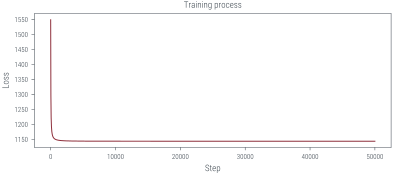

In [14]:
import tqdm

# Optimization parameters
num_steps = 50000
alpha = 0.1

# Initializations
fX = jnp.zeros_like(y_train)
losses_list = []

for step_idx in tqdm.trange(num_steps):
    # Compute loss and gradient
    loss_val, loss_grad = loss_val_and_grad(fX)
    
    # Update `fX`
    fX = fX - alpha * loss_grad
    
    # Store loss
    losses_list.append(loss_val)

# Store final `f` in `fX_hat`
fX_hat = fX

# Visualization of training process
fig, ax = plt.subplots()
ax.plot(losses_list)
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
ax.set_title("Training process")
plt.show()

### 4. Posterior GP

The posterior mean and covariance function are given by

\begin{align}
\hat{m}(x_*) 
&= m(x_*) + k(x_*, X) \cdot \nabla \log(p(y | \hat{f_X})) \\
\hat{k}(a, b)
&= k(a, b) - k(a, X)^T (k(X, X) + W^{-1})^{-1} k(X, b),
\end{align}
where $W$ is a diagonal matrix with $\text{diag}(W) = \pi \odot (1 - \pi)$ ($\odot$ denotes the element-wise product of two vectors) and $\pi = \sigma(\hat{f_X})$.

**Task:** Implement the posterior mean and covariance functions. For evaluating the posterior covariance, compute the Cholesky factorization of $k(X, X) + W^{-1}$ only once. 

In [15]:
m = prior_GP.m
ker = prior_GP.k
def posterior_mean(x):
    """Posterior mean function as defined above"""
    m_x = m(x)
    k_xX = ker(x[..., None, :], X_train[None, :, :])
    update = k_xX @ log_likelihood.grad(fX_hat)
    return m_x + update

W = logistic_func(fX_hat) * (1 - logistic_func(fX_hat))
W_inv =  jnp.diag(1 / W)
k_XX = ker(X_train[:, None, :], X_train[None, :, :])
kW_1_2, lower_kW = jax.scipy.linalg.cho_factor(k_XX + W_inv)
    
def posterior_covar(a, b):
    """Posterior covariance function as defined above"""
    k_aX = ker(a, X_train[None, :, :])
    k_Xb = ker(X_train[:, None, :], b)
    k_ab = ker(a, b)
    # Implement the posterior mean and covariance functions. For evaluating the posterior covariance, compute the Cholesky factorization of $k(X, X) + W^{-1}$ only once. 
    kW_inv_kXb = jax.scipy.linalg.cho_solve((kW_1_2, lower_kW), k_Xb)
    return k_ab - k_aX @ kW_inv_kXb

**Posterior GP:** Now, we can construct the posterior GP.

In [16]:
post_GP = gaussians.GaussianProcess(posterior_mean, posterior_covar)

### 5. Further analyses

In the following, we will use the posterior GP for further analyses. 

By evaluating the posterior GP on some data $x_*$, we obtain a Gaussian $p(f_*) = \mathcal{N}(f_*; \hat{m}(x_*), \hat{k}(x_*, x_*))$. The predictive probability for the positive class (the digit 1) is given by

$$
\mathbb{E}_{p(f_*)}[\sigma(f_*)] = \int_{f_*} \sigma(f_*) \cdot p(f_*) df_*
$$

We consider two approaches: 
1. We can approximate the predictive probability by $\mathbb{E}_{p(f_*)}[\sigma(f_*)] \approx \sigma(\hat{m}(x_*))$, i.e. by mapping the mean of the Gaussian through the logistic function. 
2. Another approximation (developed by David JC MacKay, 1992) is given by 

$$
\mathbb{E}_{p(f_*)}[\sigma(f_*)] \approx \sigma\big(\frac{\hat{m}(x_*)}{\sqrt{1 + \frac{\pi}{8} \hat{k}(x_*, x_*)}}\big).
$$

**Task:** Complete `predictive_probs_2` below. Use approach 2 to compute the predicitive probabilities for the training and test data.

In [17]:
def predictive_probs_1(gaussian):
    """Predictive probabilities from a given Gaussian `gaussian` based 
    on approach 1 above"""
    return logistic_func(gaussian.mu)


def predictive_probs_2(gaussian):
    """Predictive probabilities from a given Gaussian `gaussian` based 
    on approach 2 above"""
    m_hat = gaussian.mu
    k_hat = jnp.diag(gaussian.Sigma)
    return logistic_func(m_hat / jnp.sqrt(1 + jnp.pi * k_hat / 8))
    

# Evaluate the posterior GP on the training and test data
post_gaussian_train = post_GP(X_train)
post_gaussian_test = post_GP(X_test)

# Compute the predictive probabilities using approach 2
probs_train = predictive_probs_2(post_gaussian_train)
probs_test = predictive_probs_2(post_gaussian_test)

Next, we can use the predictive probabilities to compute confidences for the training and test data points. The confidence is given by the maximum of the probabilities over all classes. 

In [18]:
# Confidence
confs_train = np.maximum(probs_train, 1 - probs_train)
confs_test = np.maximum(probs_test, 1 - probs_test)

With those confidence vectors, we can determine the $k$ most/least certain digits.

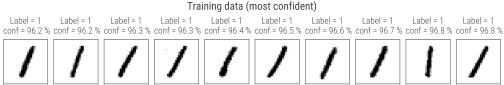

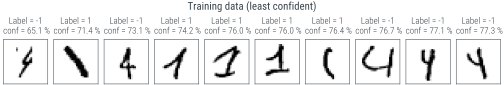

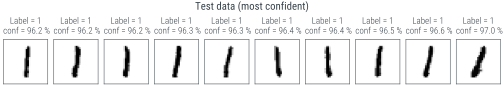

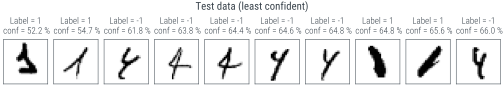

In [19]:
def show_k_most_least_confident(X_data, y_data, title, confs, k=5):
    """Plot the `k` most/least certain data points."""
    
    sorted_indides = np.argsort(confs)
    indices_most = sorted_indides[-k:]  # last k indices
    indices_least = sorted_indides[:k]  # first k indices
    
    # Set upo figures for most and least confident data points
    fig_most, axs_most = plt.subplots(1, k, figsize=(k * 0.7, 1.5))
    fig_least, axs_least = plt.subplots(1, k, figsize=(k * 0.7, 1.5))
    
    for axs, indices in zip([axs_most, axs_least], [indices_most, indices_least]):
        for ax_idx, idx in enumerate(indices):
            title_img = f"Label = {y_data[idx]}\n conf = {100 * confs[idx]:.1f} %"
            show_mnist_img(axs[ax_idx], X_data[idx, :], title_img)
    
    fig_most.suptitle(title + " (most confident)")
    fig_least.suptitle(title + " (least confident)")    
    plt.show()
    
show_k_most_least_confident(X_train, y_train, "Training data", confs_train, k=10)
show_k_most_least_confident(X_test, y_test, "Test data", confs_test, k=10)

We can also use the confidence vectors to make predictions. 

In [20]:
def predict_y(probs):
    """Compute the predicted class based on the probabilities for the 
    positive class."""
    y_pred = np.zeros_like(probs).astype(int)
    y_pred[probs >= 0.5] = 1
    y_pred[probs < 0.5] = -1
    return y_pred

y_pred_train = predict_y(probs_train)
y_pred_test = predict_y(probs_test)

By comparing the predicted classes to the ground truth (`y_train` and `y_test`), we can compute accuracies on both data sets. 

**Task:** Compute and print the training and test accuracy. *Hint*: If everything works correctly you should achieve a training accuracy of 100% and a test accuracy of 99.67%.

In [21]:
def compute_accuracy(y_pred, y_true):
    """Compute the accuracy of the predictions `y_pred` compared to the 
    true labels `y_true`."""
    return np.mean(y_pred == y_true)

acc_train = compute_accuracy(y_pred_train, y_train)
acc_test = compute_accuracy(y_pred_test, y_test)

print(f"Accuracy on training data: {100 * acc_train:.2f} %")
print(f"Accuracy on test data: {100 * acc_test:.2f} %")

Accuracy on training data: 100.00 %
Accuracy on test data: 99.67 %


We can use the function below to show the misclassified data points.

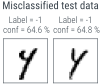

In [22]:
def show_misclassified_imgs(X_data, y_data, y_pred, confs, title):
    
    mis_indices = list((y_pred != y_data).nonzero()[0])
    num_mis = len(mis_indices)
    if num_mis == 0:
        return  # Return if no misclassifications
    
    fig, axs = plt.subplots(1, num_mis, figsize=(num_mis * 0.7, 1.5))
    for idx, mis_idx in enumerate(mis_indices):
        title_img = f"Label = {y_data[mis_idx]}\n conf = {100 * confs[mis_idx]:.1f} %"
        show_mnist_img(axs[idx], X_data[mis_idx, :], title_img)
    fig.suptitle(title)
    plt.show()

# Plot misclassified test data points
show_misclassified_imgs(X_train, y_train, y_pred_train, confs_train, "Misclassified training data")
print("")
show_misclassified_imgs(X_test, y_test, y_pred_test, confs_test, "Misclassified test data")

Finally, let's compare the two approaches for the predictive probabilities on out-of-distribution data. 

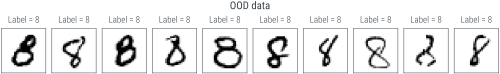


OOD data:
X.shape =  (100, 784)
X in range [-1.0, 1.0]
y.shape =  (100,)
Target yi = 8: Found 100 times


In [23]:
# Load/show the data
X_ood, y_ood = data["X_ood"], data["y_ood"]
show_n_mnist_imgs(X_ood, y_ood, "OOD data", n=10)
print_data_info(X_ood, y_ood, "OOD data")

In [24]:
# Evaluate the posterior GP on `X_ood`, compute predicted probabilities
post_gaussian_ood = post_GP(X_ood)
probs_ood_1 = predictive_probs_1(post_gaussian_ood)
probs_ood_2 = predictive_probs_2(post_gaussian_ood)

# Compute confidences
confs_ood_1 = np.maximum(probs_ood_1, 1 - probs_ood_1)
confs_ood_2 = np.maximum(probs_ood_2, 1 - probs_ood_2)

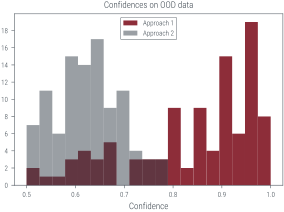

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
bins = np.linspace(0.5, 1, 20)

ax.hist(confs_ood_1, bins=bins, alpha=1.0, label="Approach 1")
ax.hist(confs_ood_2, bins=bins, alpha=0.5, label="Approach 2")
# Set y axis integer ticks
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# General settings
ax.set_title("Confidences on OOD data")
ax.set_xlabel("Confidence")
ax.legend(loc="upper center")
plt.show()

**Task:** How can the difference between the two histograms be explained? Which of the two approaches would you prefer? Explain your decision briefly. 

**Your answer:** 
In the second approach (and thus, histogram), the covariances ($\hat{k}(x_*, x_*)$) are also taken into consideration: 

$$
\mathbb{E}_{p(f_*)}[\sigma(f_*)] \approx \sigma\big(\frac{\hat{m}(x_*)}{\sqrt{1 + \frac{\pi}{8} \hat{k}(x_*, x_*)}}\big).
$$

This allows better approximation of the confidence values using predictive probabilities since intuitively, as the (co)variance of the prediction increases, confidence on the predicted value should decrease. This is achieved in the second approach by scaling the mean's effect by variance. Therefore, second approach would be preferable.

Note also that, assuming $\frac{\pi}{8} \hat{k}(x_*, x_*)<<1$:

$$\sqrt{1 + \frac{\pi}{8} \hat{k}(x_*, x_*)} \approx 1 + \frac{\pi}{16} \hat{k}(x_*, x_*)$$ 
$$
\mathbb{E}_{p(f_*)}[\sigma(f_*)] \approx \sigma\big(\frac{\hat{m}(x_*)}{1 + \frac{\pi}{16} \hat{k}(x_*, x_*)}\big).
$$

The result above further displays how the scaling effect of covariance works.

